In [1]:
# Add the parent directory to the path so that we can import the necessary modules
%cd ..
#import sys
#sys.path.append('../')

/home/tourloid/Desktop/PhD/Code/SPVD


In [2]:
#export
# import already implemented blocks
from models.modules import TimeEmbeddingBlock, SparseTransformer, SparseAttention
from models.utils import lin, timestep_embedding
from models.ddpm_unet import saved, unet_conv

In [3]:
#export 
# other exports 
import torch 
import torch.nn as nn
from functools import wraps
import torchsparse
import torchsparse.nn as spnn
from utils import model_num_params
import fastcore.all as fc
from models.sparse_utils import initial_voxelize, voxel_to_point, point_to_voxel, PointTensor

In [4]:
#export
class PointBlock(nn.Module):

    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm1d(ni), 
            nn.SiLU(), 
            nn.Linear(ni, nf)
        )

    def forward(self, z1, z):
        z1.F = z1.F + self.conv(z.F)
        return z1

In [5]:
#export 
class StemBlock(nn.Module):

    def __init__(self, ni, nf, ks=3, name='StemConv'):
        super().__init__()
        self.voxel_conv = nn.Sequential(
            spnn.Conv3d(ni, nf, kernel_size=ks), 
            spnn.BatchNorm(nf), 
            spnn.SiLU(),
            spnn.Conv3d(nf, nf, kernel_size=ks)
        )

        self.point_conv = PointBlock(ni, nf)

        self.msg = '** ' + name + ' ** \n'
        self.msg += ' -- Voxel Branch \n'
        self.msg += f' Conv3d({ni},{nf})'
        self.msg += f' - Params: {model_num_params(self.voxel_conv)} \n'
        self.msg += ' -- Point Branch \n'
        self.msg += f' PointBlock({ni},{nf})'
        self.msg += f' - Params: {model_num_params(self.point_conv)} \n'
        
    def forward(self, x, z):

        x = self.voxel_conv(x)

        z1 = voxel_to_point(x, z)
        # point residual connection
        z1 = self.point_conv(z1, z)

        # new voxel features
        x = point_to_voxel(x, z1)

        return x, z1

In [6]:
#export
from models.ddpm_unet_attn import EmbResBlock

# class EmbResBlock(nn.Module):
#     def __init__(self, n_emb, ni, nf=None, ks=3, attn_chans=None):
#         super().__init__()
#         nf = nf or ni

#         self.conv1 = unet_conv(ni, nf, ks)
#         self.conv2 = unet_conv(nf, nf, ks=1) # WARNING: This should be 3, but I change it to 1 to decrease the number of parameters
                                            

#         self.t_emb = TimeEmbeddingBlock(n_emb, nf)
        
#         self.idconv = fc.noop if ni==nf else nn.Linear(ni, nf) 

#         self.attn = False
#         if attn_chans: self.attn = SparseAttention(nf, attn_chans)

    
#     def forward(self, x_in, t):

#         # first conv
#         x = self.conv1(x_in)

#         # time embedding
#         x.F = self.t_emb(x.F, t, x.C[:, 0])

#         # second conv
#         x = self.conv2(x)

#         # residual connection
#         x.F = x.F + self.idconv(x_in.F)

#         if self.attn: 
#             x = self.attn(x)

#         return x

In [7]:
#export
class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1, attn_chans=None):
        super().__init__()
        # v1 - increase dim on first conv
        # self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni if i==0 else nf, nf, attn_chans=attn_chans), self)
        #                               for i in range(num_layers)])
        # self.down = saved(spnn.Conv3d(nf, nf, 2, stride=2),self) if add_down else nn.Identity()

        # v2 - increase dim on downsample
        self.resnets = nn.ModuleList([saved(EmbResBlock(n_emb, ni, ni, attn_chans=attn_chans), self)
                                      for i in range(num_layers)])
        self.down = saved(spnn.Conv3d(ni, nf, 2, stride=2),self) if add_down else spnn.Conv3d(ni, nf, 1)#nn.Identity()
            
    def forward(self, x, t):
        self.saved = []
        for resnet in self.resnets: x = resnet(x, t)
        x = self.down(x)
        return x

In [8]:
#export
class SPVDownStage(nn.Module):

    def __init__(self, n_emb, nfs = (32, 64, 128), add_down=(True, True), num_layers=1, attn_chans=(None, None), name='SPVDownStage'):
        super().__init__()
        self.downs = nn.ModuleList()
        nf = nfs[0]
        self.msg = '** ' + name + ' ** \n'

        self.msg += ' -- Voxel Branch \n'
        for i in range(1, len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=add_down[i-1], num_layers=num_layers,
                                        attn_chans=attn_chans[i-1]))
            self.msg += f' DownBlock({ni}, {nf}, add_down={add_down[i-1]}, num_layers={num_layers}, attn_chans={attn_chans[i-1]})'
            self.msg += f' - Params: {model_num_params(self.downs[-1])} \n'

        self.msg += ' -- Point Branch \n'
        self.point_block = PointBlock(nfs[0], nfs[-1])
        self.msg += f' PointBlock({nfs[0]},{nfs[-1]})'
        self.msg += f' - Params: {model_num_params(self.point_block)} \n'

    def forward(self, x, z, emb):

        self.saved = []

        for block in self.downs:
            x = block(x, emb)
        self.saved += [p for o in self.downs for p in o.saved]

        # move to points
        z1 = voxel_to_point(x, z)
        # point residual connection
        z1 = self.point_block(z1, z)

        # new voxel features
        x = point_to_voxel(x, z1)

        return x, z1

In [9]:
#export
UpEmbResBlock = EmbResBlock

# class UpEmbResBlock(nn.Module):
    
#     def __init__(self, n_emb, ni, nf=None, ks=3, attn_chans=None):
#         super().__init__()
#         nf = nf or ni

#         self.merge_conv = nn.Sequential(
#             nn.BatchNorm1d(ni),
#             nn.SiLU(), 
#             nn.Linear(ni, nf)
#         )

#         ni = nf
#         self.conv1 = unet_conv(ni, nf, ks)
#         self.conv2 = unet_conv(nf, nf, ks=1) # WARNING: This should be 3, but I change it to 1 to decrease the number of parameters
                                            
#         self.t_emb = TimeEmbeddingBlock(n_emb, nf)
        
#         self.idconv = fc.noop if ni==nf else nn.Linear(ni, nf) 

#         self.attn = False
#         if attn_chans: self.attn = SparseAttention(nf, attn_chans)

    
#     def forward(self, x_in, t):

#         # keep x_in for residual connection
#         x = x_in

#         # merge conv
#         x.F = self.merge_conv(x.F)
        
#         # first conv
#         x = self.conv1(x)

#         # time embedding
#         x.F = self.t_emb(x.F, t, x.C[:, 0])

#         # second conv
#         x = self.conv2(x)

#         # residual connection
#         x.F = x.F + self.idconv(x_in.F)

#         if self.attn: 
#             x = self.attn(x)

#         return x

In [10]:
#export
class UpBlock(nn.Module):
    def __init__(self, n_emb, prev_nf, ni, nf, add_up=True, num_layers=1, attn_chans=None, ks=3):
        """
        Args: 
            - prev_nf: previous feature dimension during the upsampling stage
            - ni     : input feature dimension of the corresponding downsampling stage
            - nf     : output feature dimension of the corresponding downsampling stage (not used)
        """
        super().__init__()
        self.resnets = nn.ModuleList(
            [UpEmbResBlock(n_emb = n_emb, 
                           ni = prev_nf + ni, 
                           nf = prev_nf,
                           attn_chans=attn_chans,
                           ks=ks)
            for i in range(num_layers)])

        self.up = spnn.Conv3d(prev_nf, ni, 2, stride=2, transposed=True) if add_up else spnn.Conv3d(prev_nf, ni, 1) #nn.Identity()

    def forward(self, x, t, ups):
        for resnet in self.resnets: x = resnet(torchsparse.cat([x, ups.pop()]), t)
        return self.up(x)

In [11]:
#export
class SPVUpStage(nn.Module):
    def __init__(self, n_emb, nfs = (128, 64, 32), add_up=(True, True), num_layers=1, attn_chans=(None, None), ks=(3, 3), name='SPVDUpStage'):
        super().__init__()
        self.msg = '** ' + name + ' ** \n'
        self.msg += ' -- Voxel Branch \n'
        
        self.ups = nn.ModuleList()

        nf = nfs[0]
        prev_nf = nf
        for i in range(len(nfs)-1):
            nf = nfs[i]
            ni = nfs[i+1]
            self.ups.append(UpBlock(n_emb, prev_nf, ni, nf, add_up=add_up[i], num_layers=num_layers, attn_chans=attn_chans[i], ks=ks[i]))
            self.msg += f' UpBlock({prev_nf}, {ni} | {ni}), add_up={add_up[i]}, num_layers = {num_layers}, attn_chans={attn_chans[i]}'
            self.msg += f' - Params: {model_num_params(self.ups[-1])} \n'
            prev_nf = ni

        self.msg += ' -- Point Branch \n'
        self.point_block = PointBlock(nfs[0], nfs[-1])
        self.msg += f' PointBlock({nfs[0]},{nfs[-1]})'
        self.msg += f' - Params: {model_num_params(self.point_block)} \n'

    def forward(self, x, z, emb, saved):

        for block in self.ups:
            x = block(x, emb, saved)

        # move to points
        z1 = voxel_to_point(x, z)
        # point residual connection
        z1 = self.point_block(z1, z)

        # new voxel features
        x = point_to_voxel(x, z1)

        return x, z1

In [12]:
#export
class SPVUnetSymmetric(nn.Module):
    """
        Definition of a DownBlock:
        
        Convolutions : | 32 -> 64 | 64 -> 128 | 128 -> 192 |
        Add down conv: |   True   |   True    |    True    |  (only define for the down stages, the up stages are created automatically)
        Attn chans:    |   None   |   None    |    None    |
        Kernel size:   |     3    |     3     |      3     |  (only to skip conv blocks during upsampling --> reduce parameters)
        Name:        How to call this layer

    """
    def __init__(self, point_channels=3, voxel_size=0.1, 
                 blocks = [[(32, 64, 128, 192), (True, True, True), (None, None, None), (3, 3, 3)],
                           [(192, 192, 256), (True, False), (8, 8), (3, 3)]],
                 num_layers=1, pres=1e-5):
        super().__init__()
        self.pres=pres
        self.voxel_size=voxel_size
        self.msg = f'Point Resolution: {self.pres} | Voxel Resolution: {self.voxel_size}\n'

        # time embedding
        self.n_temb = nf = blocks[0][0][0]
        n_emb = nf * 4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.msg += f'Time Embedding size - before mlp: {self.n_temb} , -after mlp: {n_emb} \n'

        self.stem_conv = StemBlock(point_channels, blocks[0][0][0])
        self.msg += self.stem_conv.msg

        add_down_vals = []
        self.down_stages = nn.ModuleList()
        for i, block_config in enumerate(blocks):
            nfs, add_down, attn_chans, _ = block_config
            add_down_vals.extend(add_down)
            name = f'Down Stage {i}'
            self.down_stages.append(SPVDownStage(n_emb, nfs=nfs, add_down=add_down, attn_chans=attn_chans, name=name, num_layers=num_layers))
            self.msg += self.down_stages[-1].msg
        
        self.mid_stages = nn.Identity()

        self.up_stages = nn.ModuleList()
        b_idx=0
        for i, block_config in enumerate(reversed(blocks)):
            nfs, _, attn_chans, ks = map(list, map(reversed, map(list, block_config)))
            add_up = add_down_vals[b_idx:b_idx+len(attn_chans)]
            b_idx = b_idx + len(attn_chans)
            name = f'Up Stage {i}'
            self.up_stages.append(SPVUpStage(n_emb, nfs=nfs, add_up=add_up, attn_chans=attn_chans, ks=ks, num_layers=num_layers+1, name=name))
            self.msg += self.up_stages[-1].msg

        self.out_conv = nn.Sequential(
            nn.BatchNorm1d(blocks[0][0][0]),
            nn.SiLU(), 
            nn.Linear(blocks[0][0][0], point_channels, bias=False),
        )

        self.msg += '** Noise Predictor ** \n'
        self.msg += f' LinearLayer({blocks[0][0][0]}, {point_channels})'
        self.msg += f' - Params: {model_num_params(self.out_conv)} \n'
        
        self.msg += f'Total Parameters: {model_num_params(self)/1e6:0.1f}M'

    def summary(self):
        print(self.msg)


    def forward(self, inp):

        # Input Processing
        x, t = inp
        z = PointTensor(x.F, x.C.float()) # CHECK
        t = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(t)

        # Initial Voxelization
        x0 = initial_voxelize(z, self.pres, self.voxel_size)

        # Stem convolution
        x, z = self.stem_conv(x0, z)

        saved = [x]

        for d in self.down_stages:
            x, z = d(x, z, emb)
            saved += [p for p in d.saved]

        #x = self.mid_stages(x, emb)

        for u in self.up_stages:
            x, z = u(x, z, emb, saved)
        
        return self.out_conv(z.F)

In [13]:
#export
class SPVUnet(nn.Module):
    """
        Definition of a DownBlock:
        
        Convolutions : | 32 -> 64 | 64 -> 128 | 128 -> 192 |
        Add down conv: |   True   |   True    |    True    |  
        Attn chans:    |   None   |   None    |    None    |
        Kernel size:   |     3    |     3     |      3     |  (only to skip conv blocks during upsampling --> reduce parameters)
        Name:        How to call this layer

    """
    def __init__(self, point_channels=3, voxel_size=0.1, 
                 down_blocks = [[(64, 128, 192, 256, 384, 384), (True, True, True, True, False), (None, None, None, 8, 8)]], # only one point skip connection during downsampling
                 up_blocks   = [[(384, 384, 256), (True, True), (8, 8), (3, 3)], 
                                [(256, 192, 128, 64), (True, True, False), (None, None, None), (3, 3, 3)]],
                 num_layers=1, pres=1e-5):
        super().__init__()
        self.pres=pres
        self.voxel_size=voxel_size
        self.msg = f'Point Resolution: {self.pres} | Voxel Resolution: {self.voxel_size}\n'

        # time embedding
        self.n_temb = nf = down_blocks[0][0][0]
        n_emb = nf * 4
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.msg += f'Time Embedding size - before mlp: {self.n_temb} , -after mlp: {n_emb} \n'

        self.stem_conv = StemBlock(point_channels, down_blocks[0][0][0])
        self.msg += self.stem_conv.msg

        add_down_vals = []
        self.down_stages = nn.ModuleList()
        for i, block_config in enumerate(down_blocks):
            nfs, add_down, attn_chans = block_config
            add_down_vals.extend(add_down)
            name = f'Down Stage {i}'
            self.down_stages.append(SPVDownStage(n_emb, nfs=nfs, add_down=add_down, attn_chans=attn_chans, name=name, num_layers=num_layers))
            self.msg += self.down_stages[-1].msg
        
        self.mid_stages = nn.Identity()

        self.up_stages = nn.ModuleList()
        for i, block_config in enumerate(up_blocks):
            nfs, add_up, attn_chans, ks = block_config
            name = f'Up Stage {i}'
            self.up_stages.append(SPVUpStage(n_emb, nfs=nfs, add_up=add_up, attn_chans=attn_chans, ks=ks, num_layers=num_layers+1, name=name))
            self.msg += self.up_stages[-1].msg

        self.out_conv = nn.Sequential(
            nn.BatchNorm1d(up_blocks[-1][0][-1]),
            nn.SiLU(), 
            nn.Linear(up_blocks[-1][0][-1], point_channels, bias=False),
        )

        self.msg += '** Noise Predictor ** \n'
        self.msg += f' LinearLayer({up_blocks[-1][0][-1]}, {point_channels})'
        self.msg += f' - Params: {model_num_params(self.out_conv)} \n'
        
        self.msg += f'Total Parameters: {model_num_params(self)/1e6:0.1f}M'

    def summary(self):
        print(self.msg)


    def forward(self, inp):

        # Input Processing
        x, t = inp
        z = PointTensor(x.F, x.C.float()) # CHECK
        t = timestep_embedding(t, self.n_temb)
        emb = self.emb_mlp(t)

        # Initial Voxelization
        x0 = initial_voxelize(z, self.pres, self.voxel_size)

        # Stem convolution
        x, z = self.stem_conv(x0, z)

        saved = [x]

        for d in self.down_stages:
            x, z = d(x, z, emb)
            saved += [p for p in d.saved]

        #x = self.mid_stages(x, emb)

        for u in self.up_stages:
            x, z = u(x, z, emb, saved)
        
        return self.out_conv(z.F)

In [14]:
model = SPVUnet()
model.summary()

Point Resolution: 1e-05 | Voxel Resolution: 0.1
Time Embedding size - before mlp: 64 , -after mlp: 256 
** StemConv ** 
 -- Voxel Branch 
 Conv3d(3,64) - Params: 115904 
 -- Point Branch 
 PointBlock(3,64) - Params: 262 
** Down Stage 0 ** 
 -- Voxel Branch 
 DownBlock(64, 128, add_down=True, num_layers=1, attn_chans=None) - Params: 320000 
 DownBlock(128, 192, add_down=True, num_layers=1, attn_chans=None) - Params: 1147904 
 DownBlock(192, 256, add_down=True, num_layers=1, attn_chans=None) - Params: 2483712 
 DownBlock(256, 384, add_down=True, num_layers=1, attn_chans=8) - Params: 4721408 
 DownBlock(384, 384, add_down=False, num_layers=1, attn_chans=8) - Params: 8900736 
 -- Point Branch 
 PointBlock(64,384) - Params: 25088 
** Up Stage 0 ** 
 -- Voxel Branch 
 UpBlock(384, 384 | 384), add_up=True, num_layers = 2, attn_chans=8 - Params: 27240960 
 UpBlock(384, 256 | 256), add_up=True, num_layers = 2, attn_chans=8 - Params: 24094720 
 -- Point Branch 
 PointBlock(384,256) - Params: 99

# TESTING THE MODEL 

In [15]:
from datasets.shapenet_pointflow_sparse import ShapeNet15kPointCloudsSparseNoisy
from functools import partial
from torch.utils.data import DataLoader
import torchsparse
from torchsparse.utils.collate import sparse_collate_fn
from pclab.utils import DataLoaders

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [38]:
path = "/home/vvrbeast/Desktop/Giannis/Data/ShapeNetCore.v2.PC15k"
path = "/home/tourloid/Desktop/PhD/Data/ShapeNetCore.v2.PC15k"

tr_dataset = ShapeNet15kPointCloudsSparseNoisy(
            categories= ['airplane'], split='train',
            tr_sample_size=2048,
            te_sample_size=2048,
            scale=1.,
            root_dir=path,
            normalize_per_shape=False,
            normalize_std_per_axis=False, 
            random_subsample=True)

te_dataset = ShapeNet15kPointCloudsSparseNoisy(
            categories= ['airplane'], split='val',
            tr_sample_size=2048,
            te_sample_size=2048,
            scale=1.,
            root_dir=path,
            normalize_per_shape=False,
            normalize_std_per_axis=False,
            random_subsample=True)

tr_dataset.set_voxel_size(1e-5)
tr_dataset.set_noise_params(beta_min=1e-5, beta_max=0.008, mode='warm0.1') #beta_max=0.02)

te_dataset.set_voxel_size(1e-5)
te_dataset.set_noise_params(beta_min=1e-5, beta_max=0.008, mode='warm0.1') #beta_max=0.02)

train_dl, valid_dl = map(partial(DataLoader, batch_size=32, shuffle=True, num_workers=8, drop_last=True, collate_fn=sparse_collate_fn), (tr_dataset, te_dataset))
dls = DataLoaders(train_dl, valid_dl)

(1, 1, 1)
Total number of data:2832
Min number of points: (train)2048 (test)2048
(1, 1, 1)
Total number of data:405
Min number of points: (train)2048 (test)2048


In [39]:
batch = next(iter(valid_dl))
pc=batch['input'].F.reshape(32, 2048, 3)
vis_batch(pc)

In [40]:
from pclab.learner import *
from pclab.utils import def_device
import fastcore.all as fc
from typing import Mapping
from copy import copy
from torcheval.metrics import Mean
from utils.callbacks import GradientClipCB
from utils.callbacks import CheckpointCB

class DDPMCB(Callback):
    
    def before_batch(self, learn): 
        pts = learn.batch['input']
        t = torch.tensor(learn.batch['t'])
        noise = learn.batch['noise']
        inp = (pts, t)
        learn.batch = (inp, noise.F)

def to_device(x, device=def_device):
    if isinstance(x, (torch.Tensor, torchsparse.SparseTensor)): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

class DeviceCBSparse(Callback):
    order = DDPMCB.order + 1
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)


class LossCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = learn.batch
        #for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=2)

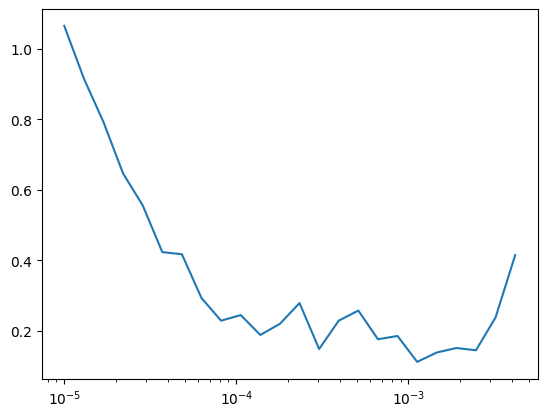

In [41]:
ddpm_cb = DDPMCB()
model = SPVUnet()
learn = TrainLearner(model, dls, nn.MSELoss(), cbs=[ddpm_cb, DeviceCBSparse(), GradientClipCB()], opt_func=torch.optim.Adam)
learn.lr_find(max_mult=3)

In [47]:
lr = 0.0001 
epochs = 200

model = SPVUnet()

# scheduler
total_steps = epochs * len(dls.train)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps = total_steps)

# Callbacks
ddpm_cb = DDPMCB()
checkpoint_cb = CheckpointCB(1000, 'airplane', run_params={'msg':model.msg})
cbs = [ddpm_cb, DeviceCBSparse(), ProgressCB(plot=False), LossCB(), GradientClipCB(), checkpoint_cb, BatchSchedCB(sched)]

learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(epochs)

loss,epoch,train
0.397,0,train
0.197,0,eval
0.175,1,train
0.168,1,eval
0.164,2,train
0.166,2,eval
0.149,3,train
0.139,3,eval
0.145,4,train
0.146,4,eval


# Inference

In [48]:
from utils.schedulers import DDPMSparseSchedulerGPU
from utils.visualization import quick_vis_batch
vis_batch = partial(quick_vis_batch, x_offset = 8, y_offset=8)

In [49]:
ddpm_sched = DDPMSparseSchedulerGPU(n_steps=1000, beta_min=1e-5, beta_max=0.008, pres=1e-5, mode='warm0.1')
preds = ddpm_sched.sample(model, 32, 2048)
vis_batch(preds)

# Test

In [ ]:
from test_generation import evaluate_gen
from utils.schedulers import DDPMSparseSchedulerGPU

In [ ]:
ddpm_sched = DDPMSparseSchedulerGPU(n_steps=1000, beta_min=0.0001, beta_max=0.02, sigma='coef_bt')
evaluate_gen(path, model, ddpm_sched, save_path='./results/', cates=['car'])

In [ ]:
ddpm_sched = DDPMSparseSchedulerGPU(n_steps=1000, beta_min=0.0001, beta_max=0.02, sigma='coef_bt')
evaluate_gen(path, model, ddpm_sched, save_path='./results/', cates=['car'])

In [ ]:
ddpm_sched = DDPMSparseSchedulerGPU(n_steps=1000, beta_min=0.0001, beta_max=0.02, sigma='coef_bt')
evaluate_gen(path, model, ddpm_sched, save_path='./results/', cates=['car'])